In [8]:
import os, sys

In [9]:
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [10]:
try:
    import keras.backend as K
    if len(K.tensorflow_backend._get_available_gpus())>0:
        print("GPUS are there")
        from keras.layers import CuDNNLSTM as LSTM
        from keras.layers import CuDNNGRU as GRU
except:
    pass

In [11]:
# some config
BATCH_SIZE = 64 # Batch size for training.
EPOCHS = 40 # Number of epochs to train for.
LATENT_DIM = 256 # Latent dimensionality of the encoding space.
NUM_SAMPLES = 10000 # Number of samples to train on.
MAX_NUM_WORDS = 20000
EMBEDDING_DIM =100

In [12]:
# where we will store the data
input_texts = [] # sentence in original language
target_texts = [] # sentence in target language
target_texts_inputs = [] # sentence in target language offset by 1

In [13]:
# load in data
# download the data at: http://www.manythings.org/anki/
t = 0
for line in open("./spa-eng/spa.txt",encoding="utf-8"):
    # only keep a limited number of samples
    t+=1
    if t > NUM_SAMPLES:
        break
    # input and target are seperated by tab
    if '\t' not in line:
        continue

    # split up the input and translation
    input_text, translation, *rest = line.rstrip().split("\t")

    # make the target input and output
    # recall we'll be using teacher forcing
    target_text = translation + ' <eos>'
    target_text_input = '<sos> ' + translation

    input_texts.append(input_text)
    target_texts.append(target_text)
    target_texts_inputs.append(target_text_input)
print("num samples:", len(input_texts))

num samples: 10000


In [14]:
# tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

In [15]:
# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print("Found %s unique input tokens." %len(word2idx_inputs))

Found 2254 unique input tokens.


In [16]:
# determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)

In [17]:
# tokenize the outputs
# dont filter out special characters
# otherwise <sos> and <eos> won't appear
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) # inefficient, oh wel
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

In [18]:
# get word to index mapping for later
word2idx_outputs = tokenizer_outputs.word_index
print("Found %s unique output tokens." % len(word2idx_outputs))

Found 6381 unique output tokens.


In [12]:
# store number of output words for later
# remember to add 1 since indexing starts at 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1

In [13]:
# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)

In [14]:
# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_inputs.shape:",encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])

decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target,padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences,maxlen=max_len_target,padding='post')

encoder_inputs.shape: (10000, 5)
encoder_inputs[0]: [ 0  0  0  0 15]
decoder_inputs[0]: [   2 1453    0    0    0    0    0    0    0    0]
decoder_inputs.shape: (10000, 10)


In [15]:
# store all the pre-trained word vectors
print("loading word vectors...")
word2vec = {}
with open('glove.6B.100d.txt',encoding="utf-8") as f:
    # is just a space-seperated text file in the format:
    # word vec[0] vec[1] vec[2] ...
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print("Found %s word vectors." % len(word2vec))

loading word vectors...
Found 400000 word vectors.


In [16]:
# prepare embedding matrix
print("Filling pre-trained embeddings...")
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
    if i< MAX_NUM_WORDS:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be zeros.
            embedding_matrix[i]=embedding_vector

Filling pre-trained embeddings...


In [17]:
# create embedding layer
embedding_layer = Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix],
                            input_length=max_len_input)

In [18]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros((len(input_texts),max_len_target,num_words_output), dtype='float32')

# assign the values
for i, d in enumerate(decoder_targets):
    for t,word in enumerate(d):
        if word!=0:
            decoder_targets_one_hot[i,t, word] =1

In [19]:
### build the model ###
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LATENT_DIM, return_state = True)

encoder_outputs, h,c = encoder(x)
# encoder_outputs, h = encoder(x) # gru

# keep only the states to pass into decoder
encoder_states = [h, c]
# encoder_states = [state_h] # gru

# set up the decoder, using [h,c] as initial state.
decoder_inputs_placeholder = Input(shape=(max_len_target,))

# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

# since the deocoder is a "to-many" model we want to have
# return_sequences = True
decoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
decoder_outputs, _,_ = decoder_lstm(decoder_inputs_x, initial_state = encoder_states)

# decoder_outputs, _ = decoder_gru(decoder_inputs_x, initial_sate=encoder_states)

# final dense layer for predictions
decoder_dense = Dense(num_words_output, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

In [20]:
# create the model object
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

In [21]:
def custom_loss(y_true, y_pred):
    # both are of shape N x T x K
    mask = K.cast(y_true > 0, dtype='float32')
    out = mask * y_true * K.log(y_pred)
    return -K.sum(out) / K.sum(mask)

def acc(y_true, y_pred):
    # both are of shape N x T x K
    targ = K.argmax(y_true, axis=-1)
    pred = K.argmax(y_pred, axis=-1)
    correct = K.cast(K.equal(targ, pred), dtype='float32')

    # 0 is padding, dont include those
    mask = K.cast(K.greater(targ, 0), dtype='float32')
    n_correct = K.sum(mask * correct)
    n_total = K.sum(mask)
    return n_correct/n_total

In [22]:
model.compile(optimizer='adam', loss=custom_loss, metrics = [acc])

# Compile the model and train it
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

r = model.fit([encoder_inputs, decoder_inputs], decoder_targets_one_hot, batch_size=BATCH_SIZE,
              epochs=EPOCHS,validation_split=0.2)


Epoch 1/40


125/125 [==============================] - 52s 264ms/step - loss: 5.9555 - acc: 0.2827 - val_loss: 5.6713 - val_acc: 0.2745
Epoch 2/40
125/125 [==============================] - 27s 213ms/step - loss: 4.9300 - acc: 0.3017 - val_loss: 5.4236 - val_acc: 0.2940
Epoch 3/40
125/125 [==============================] - 30s 243ms/step - loss: 4.5478 - acc: 0.3294 - val_loss: 5.2681 - val_acc: 0.3133
Epoch 4/40
125/125 [==============================] - 93s 748ms/step - loss: 4.2316 - acc: 0.3539 - val_loss: 5.1253 - val_acc: 0.3274
Epoch 5/40
125/125 [==============================] - 34s 270ms/step - loss: 3.9390 - acc: 0.3807 - val_loss: 5.0407 - val_acc: 0.3464
Epoch 6/40
125/125 [==============================] - 30s 238ms/step - loss: 3.6627 - acc: 0.4121 - val_loss: 4.9294 - val_acc: 0.3666
Epoch 7/40
125/125 [==============================] - 31s 245ms/step - loss: 3.4202 - acc: 0.4370 - val_loss: 4.8734 - val_acc: 0.3896
Epoch 8/40
125/125 [==============================] 

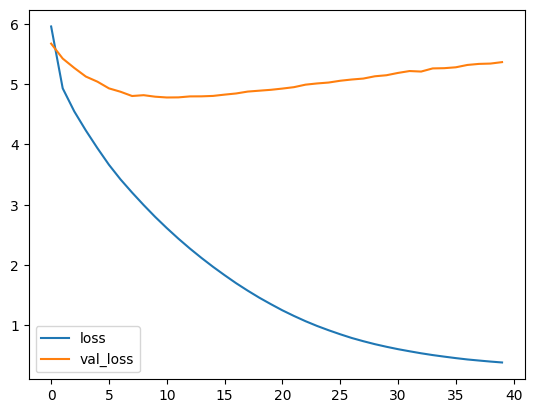

In [23]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

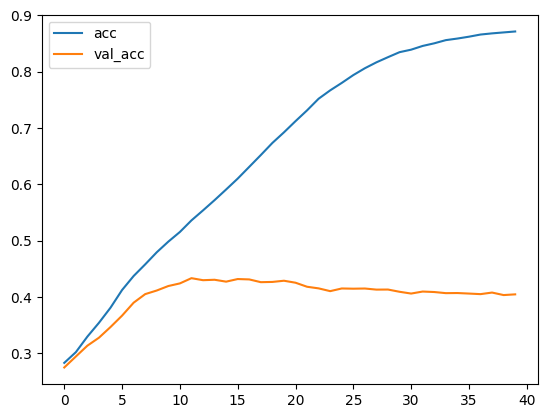

In [24]:
# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [25]:
# save model
model.save('s2s.h5')

C:\Users\te20312262\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
### make predictions ###
# As with the peotry example, we need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# decoder_states_inputs = [decoder_state_input_h] # gru

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# this time, we want to keep the states too, to be  output
# by our sampling model
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
# decoder_outputs, state_h = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_sates_inputs) # gru
decoder_states = [h, c]
# decoder_states = [h] # gru
decoder_outputs = decoder_dense(decoder_outputs)

# The sampling model
# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

In [27]:
# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [28]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first character of target sequence with the start character.
    # Note: tokenizer lower-cases all words
    target_seq[0,0] = word2idx_outputs['<sos>']

    # if we get this we break
    eos = word2idx_outputs['<eos>']

    # create the translation
    output_sentence = []
    for _ in range(max_len_target):
        output_tokens, h, c =decoder_model.predict([target_seq] + states_value)
        # output_tokens, h = decoder_model.predict([target_seq] + states_value) # gru

        # get the next word
        idx = np.argmax(output_tokens[0,0,:])

        # end sentence of EOS
        if eos == idx:
            break
    
        word = ''
        if idx > 0:
            word = idx2word_trans[idx]
            output_sentence.append(word)
        # update the decoder input
        # which is just the word just generated
        target_seq[0,0] = idx
    
        # update states
        states_value =[h, c]
        # states_value = [h] # gru
    
    return ' '.join(output_sentence)

In [29]:
while True:
    # do some test translations
    i = np.random.choice(len(input_texts))
    input_seq = encoder_inputs[i: i+1]
    translation = decode_sequence(input_seq)
    print("-")
    print("Input:", input_texts[i])
    print("Translation:", translation)

    ans = input("Continue? [Y/n]")
    if ans and ans.lower().startswith('n'):
        break

1/1 [==============================] - 0s 76ms/step
-
Input: I'm very blunt.
Translation: soy muy rudo.


Continue? [Y/n] y


1/1 [==============================] - 0s 71ms/step
-
Input: Do it quickly.
Translation: hazlo rápido.


Continue? [Y/n] y


1/1 [==============================] - 0s 72ms/step
-
Input: They quarreled.
Translation: obedecieron.


Continue? [Y/n] n


In [7]:
word2idx_outputs

NameError: name 'word2idx_outputs' is not defined

In [32]:
input_texts

['Go.',
 'Go.',
 'Go.',
 'Go.',
 'Hi.',
 'Run!',
 'Run!',
 'Run!',
 'Run!',
 'Run!',
 'Run.',
 'Run.',
 'Who?',
 'Wow!',
 'Duck!',
 'Duck!',
 'Duck!',
 'Duck!',
 'Duck!',
 'Fire!',
 'Fire!',
 'Fire!',
 'Help!',
 'Help!',
 'Help!',
 'Hide.',
 'Jump!',
 'Jump.',
 'Jump.',
 'Stay.',
 'Stay.',
 'Stay.',
 'Stay.',
 'Stop!',
 'Stop!',
 'Stop!',
 'Wait!',
 'Wait!',
 'Wait!',
 'Wait.',
 'Wait.',
 'Wait.',
 'Wait.',
 'Begin.',
 'Do it.',
 'Go on.',
 'Go on.',
 'Hello!',
 'Hello.',
 'Hurry!',
 'Hurry!',
 'Hurry!',
 'I hid.',
 'I hid.',
 'I hid.',
 'I hid.',
 'I ran.',
 'I ran.',
 'I try.',
 'I won!',
 'I won!',
 'Oh no!',
 'Relax.',
 'Relax.',
 'Shoot!',
 'Shoot!',
 'Shoot!',
 'Shoot!',
 'Shoot!',
 'Shoot!',
 'Shoot!',
 'Smile.',
 'Sorry?',
 'Attack!',
 'Attack!',
 'Attack!',
 'Attack!',
 'Attack!',
 'Buy it.',
 'Buy it.',
 'Eat it.',
 'Eat it.',
 'Eat it.',
 'Eat it.',
 'Exhale.',
 'Exhale.',
 'Exhale.',
 'Exhale.',
 'Exhale.',
 'Get up.',
 'Go now.',
 'Go now.',
 'Go now.',
 'Go now.',
 'Go no